In [1]:
from gnd_dataset import GNDDataset
import pickle
import yaml
from ast import literal_eval
import torch
from torch.nn import Embedding
import transformers
from transformers import  pipeline
from retriever import Retriever
from tqdm import tqdm
from prompt_str import SYSTEM_PROMPT, CONTEXT_PROMPT
from utils import process_output, map_labels, k_hop_neighbors, get_pref_label, get_relation_type, init_prompt_model
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
transformers.logging.set_verbosity_error()
from gnd_dataset import GNDDataset

/home/katja/projects/xmlc-knowledge/ki-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
data_dir = "data/title"

gnd_graph = pickle.load(open("data/gnd.pickle", "rb"))
index = pickle.load(open("search_indices/ft_label_index.pkl", "rb"))
mapping = pickle.load(open("data/label_mapping.pkl", "rb"))

In [3]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

retriever = Retriever(
    retriever_model=config["sentence_transformer_model"],
    device=DEVICE,
)


FileNotFoundError: [Errno 2] No such file or directory: 'config.yaml'

In [4]:
ds = GNDDataset(data_dir="datasets/text-context_0-hops_None-relation_2-k_titlewise-True",
                gnd_graph=gnd_graph,
                config=config,
                load_from_disk=True,)

In [14]:
label_freq = ds.label_frequency(
    ds["train"]["label-ids"],
)

In [5]:
res = pd.read_csv("results/prompt-tuning-baseline/predictions-{split}-{checkpoint}.csv")
res["reranked-predictions"] = res["reranked-predictions"].apply(literal_eval)
res["predictions"] = res["predictions"].apply(literal_eval)
res["label-ids"] = res["label-ids"].apply(literal_eval)


In [9]:
res["n_predictions"] = res["reranked-predictions"].str.len()
res["n_gold"] = res["label-ids"].str.len()

In [ ]:
import seaborn as sns

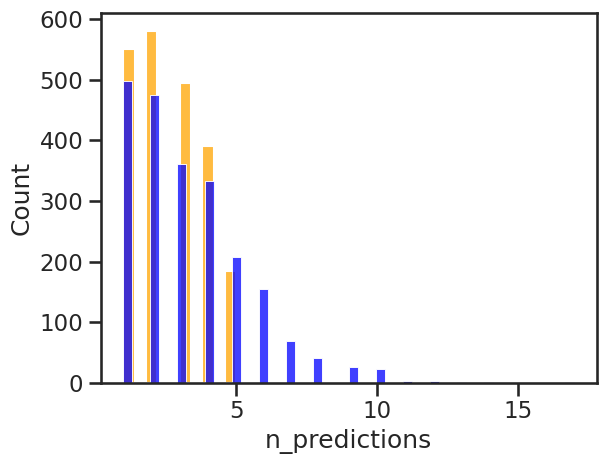

In [20]:
# histogram of n_predictions abd n_gold
sns.histplot(res["n_predictions"], bins=10, color='orange')
sns.histplot(res["n_gold"] , bins=50, color='blue')
plt.show()

In [64]:
# Evaluate label-wise accuracy
macro_prec = {

}
for index, result in tqdm(res.iterrows()):
    result_predictions = result["reranked-predictions"]
    result_labels = result["label-ids"]
    for label in result_predictions:
        if label not in macro_prec:
            macro_prec[label] = {   
                "tp": 0,
                "fp": 0,
                "fn": 0,
            }
        if label in result_labels:
            macro_prec[label]["tp"] += 1
        else:
            macro_prec[label]["fp"] += 1
    for label in result_labels:
        if label not in macro_prec:
            macro_prec[label] = {
                "tp": 0,
                "fp": 0,
                "fn": 0,
            }
        if label in result_predictions:
            macro_prec[label]["fn"] += 1
    

2200it [00:00, 20647.17it/s]


In [65]:
results = {}
for label, values in macro_prec.items():
    results[label] = {
        "precision": 0,
        "recall": 0,
    }
    if values["tp"] + values["fp"] > 0:
        results[label]["precision"] = values["tp"] / (values["tp"] + values["fp"])
    if values["tp"] + values["fn"] > 0:
        results[label]["recall"] = values["tp"] / (values["tp"] + values["fn"])


In [66]:
avg_macro_prec = 0
for label in results:
    avg_macro_prec += results[label]["precision"]
avg_macro_prec /= len(macro_prec)
print("Average Macro Precision: ", avg_macro_prec)

avg_macro_recall = 0
for label in results:
    avg_macro_recall += results[label]["recall"]
avg_macro_recall /= len(macro_prec)
print("Average Macro Recall: ", avg_macro_recall)

Average Macro Precision:  0.16431712209371208
Average Macro Recall:  0.09186746987951808


In [61]:
# Group the labels by their frequency
label_freq_grouped_prec = {
    0: [],
    10: [],
    100: [],
    1000: [],
    10000: [],
    100000: [],
}

label_freq_grouped_rec = {
    0: [],
    10: [],
    100: [],
    1000: [],
    10000: [],
    100000: [],
}

for label in macro_prec:
    freq = label_freq.get(label, 0)
    macro_prec_i = results[label]["precision"]
    macro_rec_i = results[label]["recall"]
    sort_bins = sorted(label_freq_grouped_prec.keys())
    for i in sort_bins:
        if freq <= i:
            label_freq_grouped_prec[i].append(macro_prec_i)
            label_freq_grouped_rec[i].append(macro_rec_i)
            break


In [62]:
# Average the precision for each group
avg_macro_prec_grouped = { 
    key: sum(label_freq_grouped_prec[key]) / len(label_freq_grouped_prec[key])
    for key in label_freq_grouped_prec
}

avg_macro_rec_grouped = { 
    key: sum(label_freq_grouped_rec[key]) / len(label_freq_grouped_rec[key])
    for key in label_freq_grouped_rec
}

for key in avg_macro_prec_grouped:
    print(f"Average Macro Precision for labels with frequency <= {key}: ", avg_macro_prec_grouped[key])
    print(f"Support for labels with frequency <= {key}: ", len(label_freq_grouped_prec[key]))
# Average the recall for each group
for key in avg_macro_rec_grouped:
    print(f"Average Macro Recall for labels with frequency <= {key}: ", avg_macro_rec_grouped[key])

Average Macro Precision for labels with frequency <= 0:  0.0761904761904762
Support for labels with frequency <= 0:  525
Average Macro Precision for labels with frequency <= 10:  0.17396679618509361
Support for labels with frequency <= 10:  2831
Average Macro Precision for labels with frequency <= 100:  0.1671947194719472
Support for labels with frequency <= 100:  2525
Average Macro Precision for labels with frequency <= 1000:  0.17267806267806268
Support for labels with frequency <= 1000:  1755
Average Macro Precision for labels with frequency <= 10000:  0.26100471065765607
Support for labels with frequency <= 10000:  218
Average Macro Precision for labels with frequency <= 100000:  0.3678283410138249
Support for labels with frequency <= 100000:  5
Average Macro Recall for labels with frequency <= 0:  0.0380952380952381
Average Macro Recall for labels with frequency <= 10:  0.08707170611091487
Average Macro Recall for labels with frequency <= 100:  0.08574257425742575
Average Macro Re

In [ ]:
pred_idn = "1286860482"

In [ ]:
gnd_graph[pred_idn]

In [ ]:
# Follow all neighbors with relation "broader" until no longer possible

path = [pred_idn]
while True:
    current_idn = path[-1]
    neighbors = list(gnd_graph.neighbors(current_idn))
    has_broader = False
    for neighbor in neighbors:
        rel = gnd_graph[current_idn][neighbor]["relation"]
        if rel == "broader":
            path.append(neighbor)
            has_broader = True
    if not has_broader:
        break


In [ ]:
for p in path:
    print(get_pref_label(gnd_graph, p))

In [ ]:
model, tokenizer = init_prompt_model(model_name=config["model_name"], prompt_config=config["prompt_config"])

In [ ]:
model.get_input_embeddings()

In [ ]:
d = GNDDataset(
    data_dir="data/text_0hops_None-relation_1k_titlewiseFalse/",
    gnd_graph="data/gnd.pickle", 
    config=config,
    load_from_disk=True,
)

In [ ]:
d["validate"][0]

In [ ]:
gnd_ds = GNDDataset(
    data_dir=data_dir,
    gnd_graph=gnd_graph,
    config=config
)
gnd_ds.add_context(
    retriever=retriever,
    index=index,
    mapping=mapping,
    context_type="graph",
    k=3,
    hops=2,
    relation="broader", 
    use_title_wise=False, 
    batch_size=1024,
    splits=["validate"]
)

In [ ]:
ex_context_graph = gnd_ds["validate"][0]["context"][0]

In [ ]:
H = nx.node_link_graph(ex_context_graph, edges="edges")

In [ ]:

labels = {node_id: get_pref_label(gnd_graph, node_id) for node_id in H.nodes}
edge_labels = {(head, tail): get_relation_type(H, head=head, tail=tail) for head, tail in H.edges}

In [ ]:
pos = nx.spring_layout(H)
nx.draw(H, pos,  with_labels=True, font_size=7, font_weight="bold", labels=labels, node_size=500, node_color='pink', alpha=0.9,)
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
nx.node_link_data(gnd_graph, edges="edges")